In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, RepeatVector, TimeDistributed, Input
from sklearn.preprocessing import MinMaxScaler

In [5]:
file = "./Data/clean_regional_data.csv"
df = pd.read_csv(file)

In [6]:
# Select relevant columns
features = [
    "Year",
    "GDP per capita (current US$)",
    "Electric power consumption (kWh per capita)",
    "Population, total",
    "Investment in energy with private participation (current US$)",
    "Public private partnerships investment in energy (current US$)"
]
df = df[features]

In [7]:
# Drop missing values
df.dropna(inplace=True)

In [8]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(columns=["Year"]))

In [9]:
# Create sequences for LSTM
def create_sequences(data, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][-2:])  # Predicting last two investment columns
    return np.array(X), np.array(y)

In [10]:
seq_length = 5  # Lookback window
X, y = create_sequences(df_scaled, seq_length)

In [11]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(y.shape[1])  # Output layer for investment predictions
])

model.compile(optimizer='adam', loss='mse')

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0225 - val_loss: 0.0166
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0146 - val_loss: 0.0111
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - val_loss: 0.0105
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - val_loss: 0.0076
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_l

In [14]:
# Predict future values
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


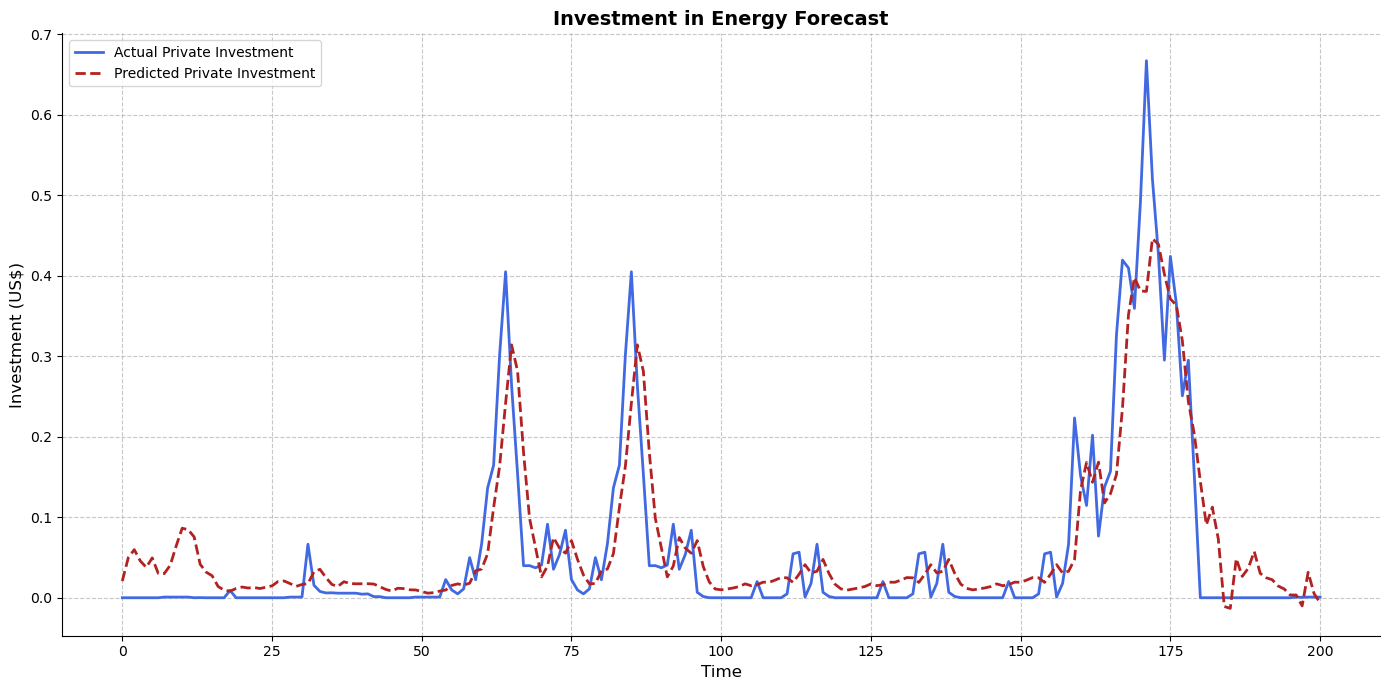

In [19]:
plt.figure(figsize=(14, 7))  # Adjust figure size for better readability

plt.plot(y_test[:, 0], label='Actual Private Investment', linewidth=2, color='royalblue')  # Increased linewidth, distinct color
plt.plot(y_pred[:, 0], label='Predicted Private Investment', linestyle='--', linewidth=2, color='firebrick')  # Increased linewidth, distinct color

plt.xlabel("Time", fontsize=12)  # Larger font size
plt.ylabel("Investment (US$)", fontsize=12)  # Larger font size
plt.title("Investment in Energy Forecast", fontsize=14, fontweight="bold")  # Larger, bolder title

plt.legend(fontsize=10, loc="upper left")  # Improved legend font size and location

plt.grid(True, linestyle="--", alpha=0.7)  # Added a grid for better readability

# Improve plot aesthetics
sns.despine()  # Remove spines
plt.tight_layout()  # Adjust layout to prevent overlapping

# Optional: Format y-axis if values are very large or small
# Example for very large values (e.g., millions/billions):
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')) # Format in millions with "M"

# Example for very small values:
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Format to 2 decimal places

plt.show()

In [20]:
# Create sequences for forecasting
def create_sequences(data, seq_length=5, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length + forecast_horizon - 1][-2:])  # Predicting last two investment columns
    return np.array(X), np.array(y)

In [21]:
seq_length = 5  # Lookback window
forecast_horizon = 3  # Predict 3 steps ahead
X, y = create_sequences(df_scaled, seq_length, forecast_horizon)

In [22]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [25]:
# Build hybrid LSTM-GRU model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(y.shape[1])  # Output layer for investment predictions
])

model.compile(optimizer='adam', loss='mse')

In [26]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0167 - val_loss: 0.0172
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 - val_loss: 0.0187
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0128
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - val_loss: 0.0141
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0115
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0135
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0142
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0140
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - val_l

In [27]:
# Predict future values
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


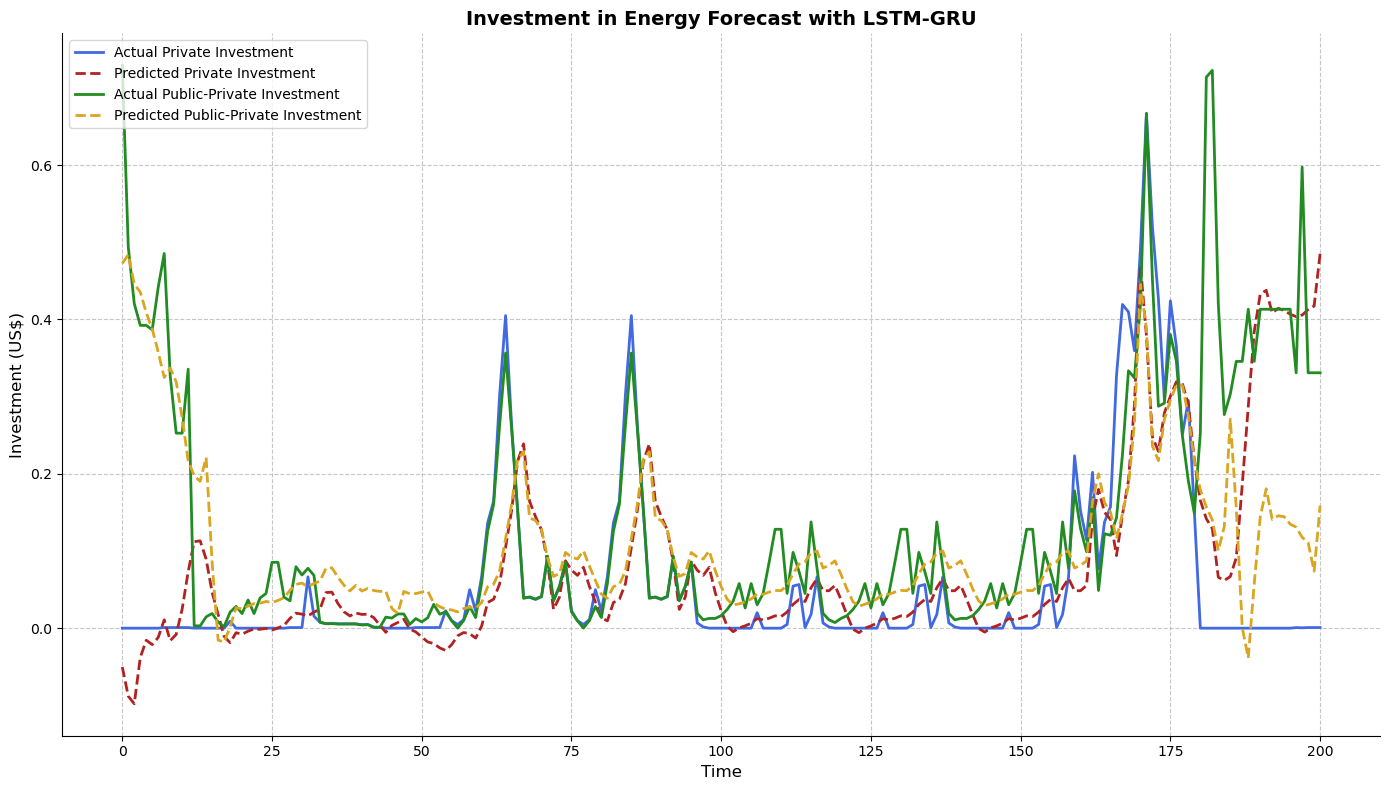

In [31]:
plt.figure(figsize=(14, 8))  # Adjust figure size for better readability

plt.plot(y_test[:, 0], label='Actual Private Investment', linewidth=2, color='royalblue')
plt.plot(y_pred[:, 0], label='Predicted Private Investment', linestyle='--', linewidth=2, color='firebrick')
plt.plot(y_test[:, 1], label='Actual Public-Private Investment', linewidth=2, color='forestgreen')  # Added distinct color
plt.plot(y_pred[:, 1], label='Predicted Public-Private Investment', linestyle='--', linewidth=2, color='goldenrod')  # Added distinct color

plt.xlabel("Time", fontsize=12)
plt.ylabel("Investment (US$)", fontsize=12)
plt.title("Investment in Energy Forecast with LSTM-GRU", fontsize=14, fontweight="bold")

plt.legend(fontsize=10, loc="upper left")  # Improved legend

plt.grid(True, linestyle="--", alpha=0.7)  # Added a grid

# Improve plot aesthetics
sns.despine()  # Remove spines
plt.tight_layout()  # Adjust layout

# Optional: Format y-axis if values are very large or small (same as before)
# plt.gca().yaxis.set_major_formatter(...)  # See previous example

# Optional: If your x-axis is time-based, consider formatting it
# Example (if your x-axis is a date array):
# import matplotlib.dates as mdates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Customize format
# plt.xticks(rotation=45, ha='right')  # Rotate labels if needed

plt.show()

<Figure size 1400x800 with 0 Axes>

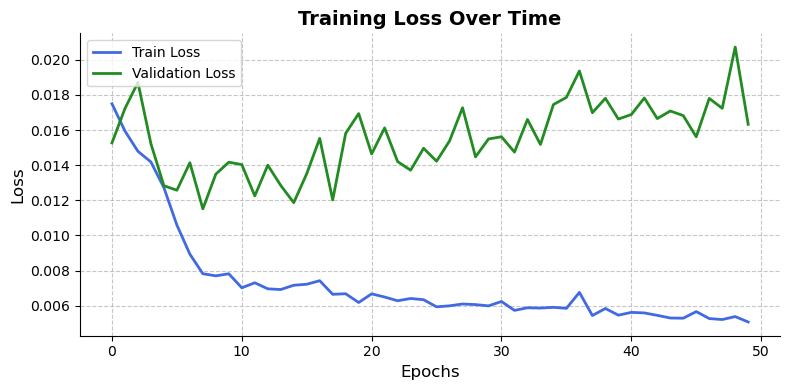

In [32]:
# Plot training loss
plt.figure(figsize=(14, 8))

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='royalblue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='forestgreen')
plt.legend()
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Over Time", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper left")  # Improved legend

plt.grid(True, linestyle="--", alpha=0.7)  # Added a grid

# Improve plot aesthetics
sns.despine()  # Remove spines
plt.tight_layout()  # Adjust layout
plt.show()

In [34]:
# Create sequences for Seq2Seq forecasting
def create_sequences(data, seq_length=5, forecast_horizon=3):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon, -2:])  # Predicting last two investment columns
    return np.array(X), np.array(y)

In [35]:
seq_length = 5  # Lookback window
forecast_horizon = 3  # Predict next 3 years
X, y = create_sequences(df_scaled, seq_length, forecast_horizon)

In [36]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [37]:
# Build Sequence-to-Sequence LSTM-GRU model
encoder_inputs = Input(shape=(seq_length, X.shape[2]))
encoder = LSTM(64, return_sequences=True)(encoder_inputs)
encoder = Dropout(0.2)(encoder)
encoder = GRU(32, return_sequences=False)(encoder)
encoder_output = RepeatVector(forecast_horizon)(encoder)

In [38]:
# Decoder
decoder = LSTM(64, return_sequences=True)(encoder_output)
decoder = Dropout(0.2)(decoder)
decoder = GRU(32, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(y.shape[2]))(decoder)

In [41]:
# Compile Model
model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mse')

In [42]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0331 - val_loss: 0.0153
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0212 - val_loss: 0.0136
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - val_loss: 0.0138
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - val_loss: 0.0125
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - val_loss: 0.0117
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0087 - val_loss: 0.0097
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - val_loss: 0.0098
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0081

In [43]:
# Predict future values
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step


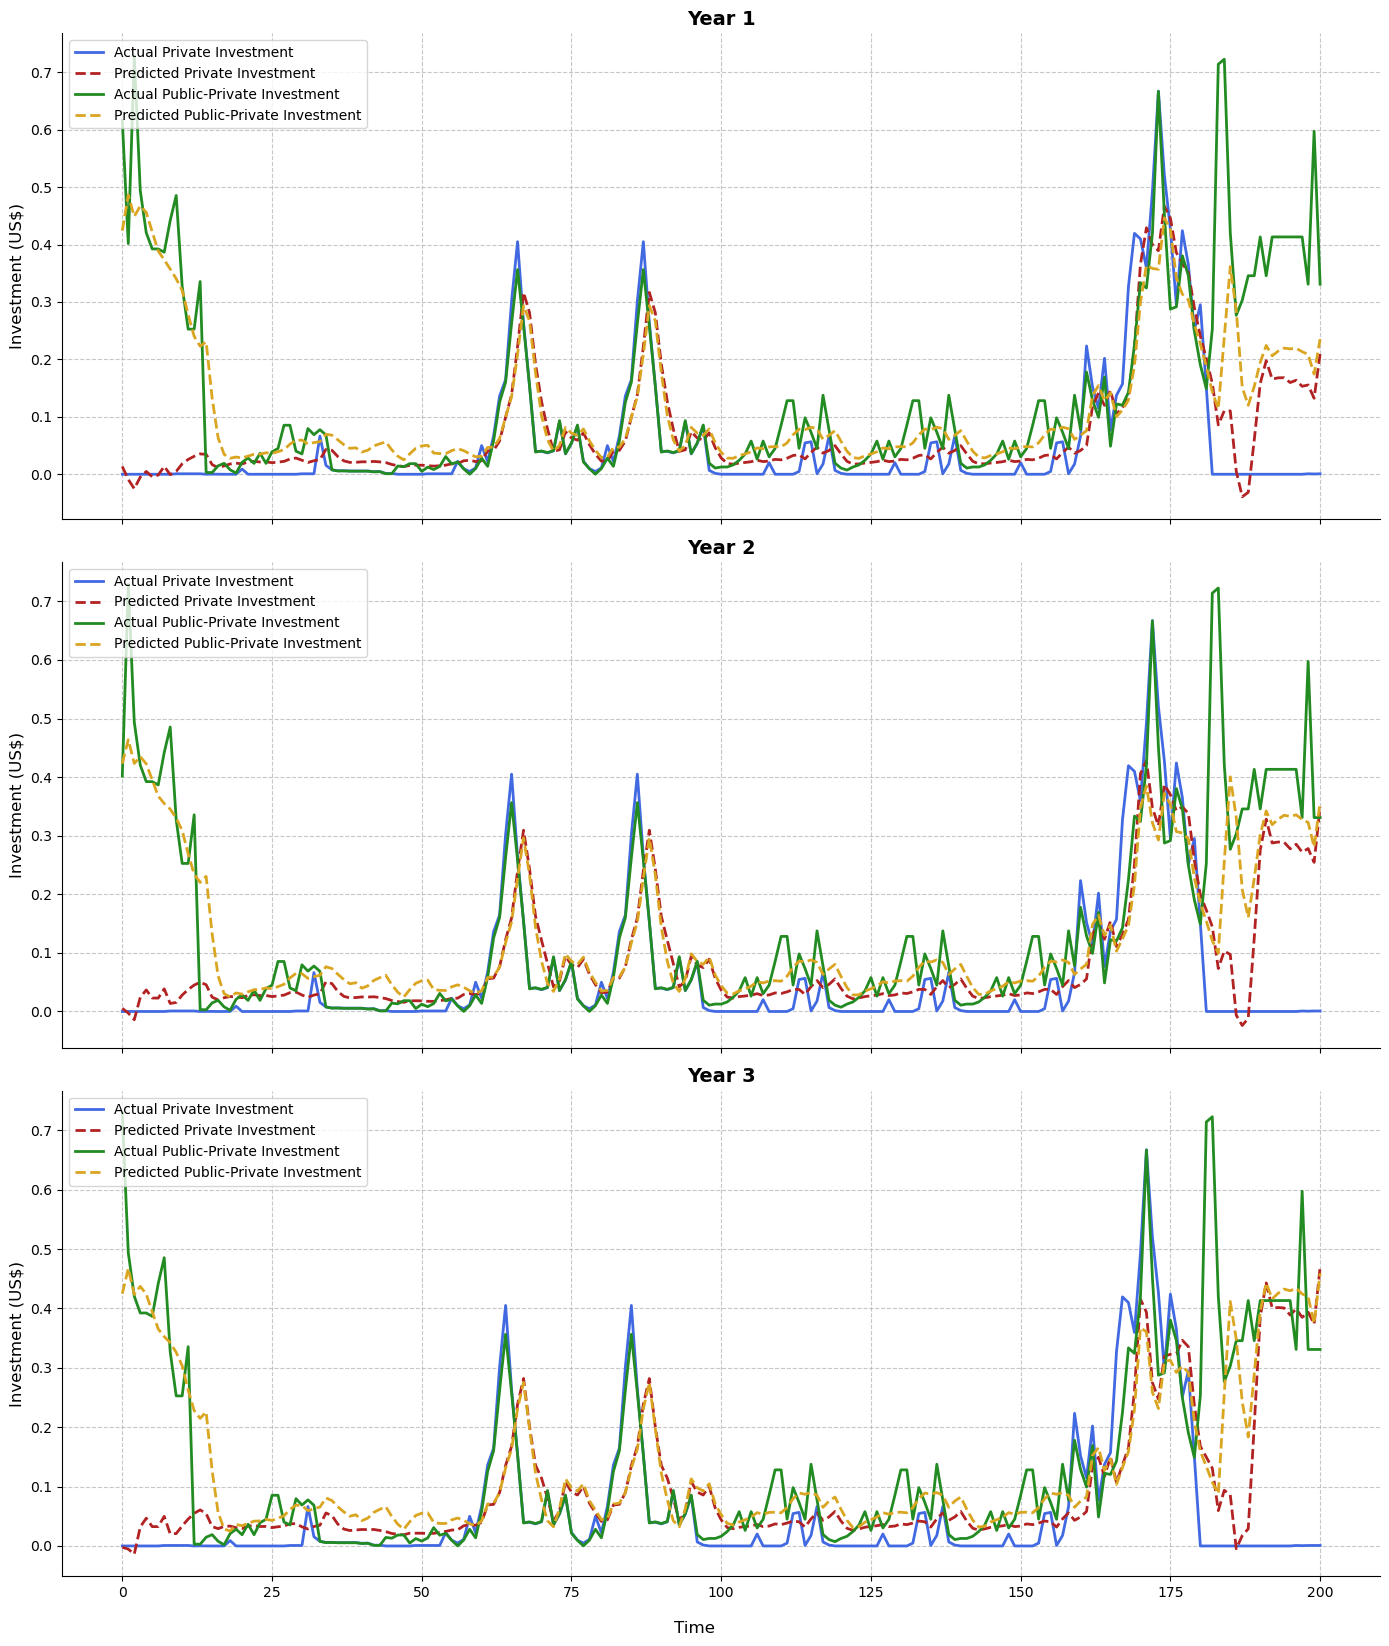

In [47]:
forecast_horizon = y_test.shape[1] #Get forecast horizon dynamically

fig, axes = plt.subplots(forecast_horizon, 1, figsize=(14, 6 * forecast_horizon), sharex=True)  # Adjust figure height dynamically

for i in range(forecast_horizon):
    ax = axes[i] if forecast_horizon > 1 else axes # Handle cases where forecast_horizon is 1
    ax.plot(y_test[:, i, 0], label='Actual Private Investment', linewidth=2, color='royalblue')
    ax.plot(y_pred[:, i, 0], label='Predicted Private Investment', linestyle='--', linewidth=2, color='firebrick')
    ax.plot(y_test[:, i, 1], label='Actual Public-Private Investment', linewidth=2, color='forestgreen')
    ax.plot(y_pred[:, i, 1], label='Predicted Public-Private Investment', linestyle='--', linewidth=2, color='goldenrod')

    ax.set_ylabel("Investment (US$)", fontsize=12)
    ax.set_title(f"Year {i+1}", fontsize=14, fontweight="bold")
    ax.legend(fontsize=10, loc="upper left")
    ax.grid(True, linestyle="--", alpha=0.7)
    sns.despine(ax=ax)  # Remove spines for each subplot

if forecast_horizon > 1: #Set common xlabel only if there are multiple subplots
    fig.text(0.5, 0.04, 'Time', ha='center', fontsize=12)  # Common x-axis label

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent overlapping, give some space at the bottom for common label
plt.show()

<Figure size 1400x800 with 0 Axes>

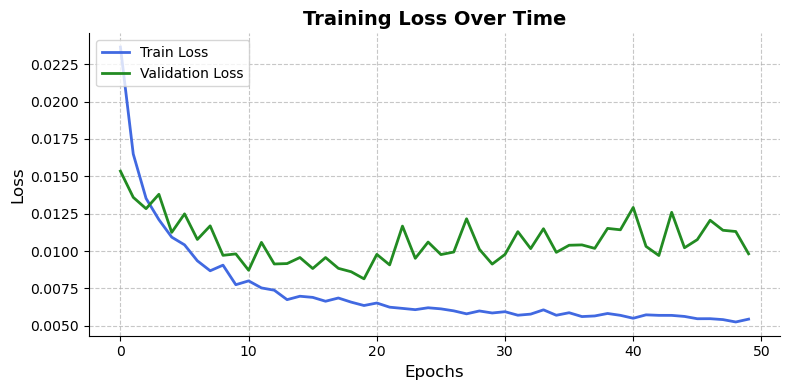

In [49]:
# Plot training loss
plt.figure(figsize=(14, 8))

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='royalblue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='forestgreen')
plt.legend()
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Over Time", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper left")  # Improved legend

plt.grid(True, linestyle="--", alpha=0.7)  # Added a grid

# Improve plot aesthetics
sns.despine()  # Remove spines
plt.tight_layout()  # Adjust layout
plt.show()